#Criação inicial do nosso modelo em base a nossa ideia descrita na documentação


Primeiro passo: Bibliotecas


In [7]:
# Importação de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.cluster import KMeans
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow import keras


Segundo passo: Carregamento e preparação dos dados

In [11]:

df = pd.read_csv('/content/dataset_odontologico.csv')

# Tratamento de dados faltantes, se necessário
df.fillna(method='ffill', inplace=True)

# Convertendo colunas de data, se necessário
df['data_nascimento'] = pd.to_datetime(df['data_nascimento'])

# Codificando variáveis categóricas
df = pd.get_dummies(df, columns=['tipo_plano', 'status_do_prontuario', 'especialidade', 'tipo_consulta'], drop_first=True)

# Verificando os dados
print(df.head())


            nome data_nascimento prontuario    custo  tipo_plano_Integral PME  \
0    Helena Lima      1986-04-20    P-72430  1657.91                    False   
1  Lucas Martins      1976-07-02    P-85293  1253.28                    False   
2    Helena Lima      1966-10-25    P-87256   450.24                    False   
3  Gabriel Souza      1987-12-17    P-94096   160.65                     True   
4    Diego Costa      1961-01-10    P-90923   953.52                    False   

   tipo_plano_Master PME  status_do_prontuario_Em tratamento  \
0                  False                               False   
1                  False                                True   
2                  False                               False   
3                  False                                True   
4                  False                                True   

   status_do_prontuario_Fechado  especialidade_Endodontia  \
0                         False                     False   
1     

<ipython-input-11-4b4396fce27e>:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


Terceiro passo: Análise exploratória

           data_nascimento        custo
count                  200   200.000000
mean   1986-08-03 05:09:36  1105.910450
min    1960-02-10 00:00:00   100.700000
25%    1975-11-22 12:00:00   631.177500
50%    1986-08-25 12:00:00  1143.880000
75%    1997-03-30 00:00:00  1595.220000
max    2010-10-26 00:00:00  1996.220000
std                    NaN   556.373227


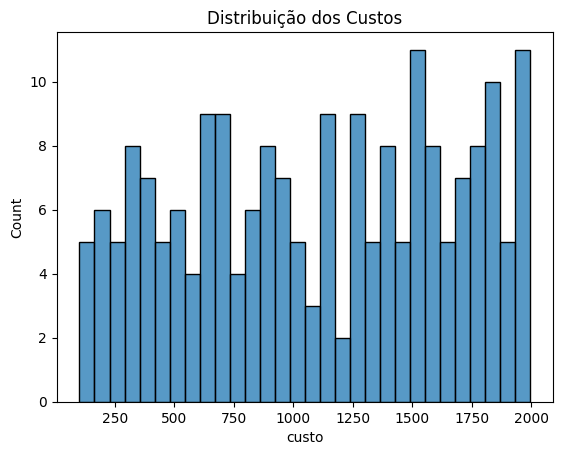

In [12]:
# Estatísticas descritivas
print(df.describe())

# Visualização da distribuição de custos
sns.histplot(df['custo'], bins=30)
plt.title('Distribuição dos Custos')
plt.show()



#Quarto passo: Modelos preditivos

1. Regressão logística

In [18]:
# Remover colunas não numéricas e a coluna de data
X = df.drop(columns=['custo', 'nome', 'prontuario', 'data_nascimento',
                     'status_do_prontuario_Em tratamento', 'status_do_prontuario_Fechado'])
y = df['status_do_prontuario_Fechado']

# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializando o modelo de Regressão Logística
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train, y_train)

# Avaliando a acurácia do modelo
accuracy = model_lr.score(X_test, y_test)
print(f'Acurácia da Regressão Logística: {accuracy:.2f}')


Acurácia da Regressão Logística: 0.55


2. Random Forest

In [19]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

accuracy_rf = model_rf.score(X_test, y_test)
print(f'Acurácia da Random Forest: {accuracy_rf:.2f}')


Acurácia da Random Forest: 0.60


Sexto passo: Detecção de Anomalias com Isolation Forest

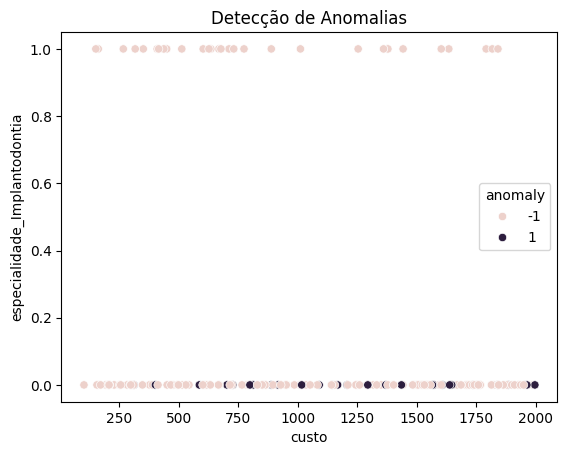

In [20]:
model_if = IsolationForest()
df['anomaly'] = model_if.fit_predict(X)

# Visualização dos dados com anomalias
sns.scatterplot(x='custo', y='especialidade_Implantodontia', hue='anomaly', data=df)
plt.title('Detecção de Anomalias')
plt.show()


Sétimo passo: K-means

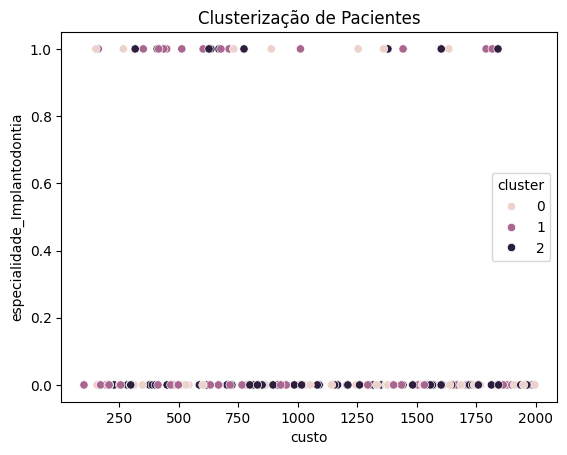

In [21]:
kmeans = KMeans(n_clusters=3)
df['cluster'] = kmeans.fit_predict(X)

# Visualizando os clusters
sns.scatterplot(x='custo', y='especialidade_Implantodontia', hue='cluster', data=df)
plt.title('Clusterização de Pacientes')
plt.show()


Oitavo passo: Modelagem de Séries Temporais com ARIMA

In [26]:
# Contando atendimentos por prontuário
df['data'] = pd.date_range(start='2023-01-01', periods=len(df), freq='D')
atendimentos_por_prontuario = df.groupby('prontuario').size().reset_index(name='atendimentos')

df_atendimentos = df[['data', 'prontuario']].copy()
df_atendimentos['count'] = 1

# Contando atendimentos por data
df_aggregated = df_atendimentos.groupby(['data']).count().reset_index()

# Definindo a data como índice
df_aggregated.set_index('data', inplace=True)

# Ajustando o modelo ARIMA
model = ARIMA(df_aggregated['count'], order=(1, 1, 1))  # Use a coluna de contagem de atendimentos
model_fit = model.fit()

# Resumindo o do modelo
print(model_fit.summary())



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1431: RuntimeWarning: invalid value encountered in divide
  test_statistic = numer_squared_sum / denom_

                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                  200
Model:                 ARIMA(1, 1, 1)   Log Likelihood                2393.853
Date:                Tue, 29 Oct 2024   AIC                          -4781.706
Time:                        02:32:38   BIC                          -4771.826
Sample:                    01-01-2023   HQIC                         -4777.707
                         - 07-19-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1      -3.297e-10   2.57e-19  -1.28e+09      0.000    -3.3e-10    -3.3e-10
ma.L1      -3.297e-10   2.57e-19  -1.28e+09      0.000    -3.3e-10    -3.3e-10
sigma2      5.017e-12   1.35e-10      0.037      0.9

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


Visualizando em grafíco

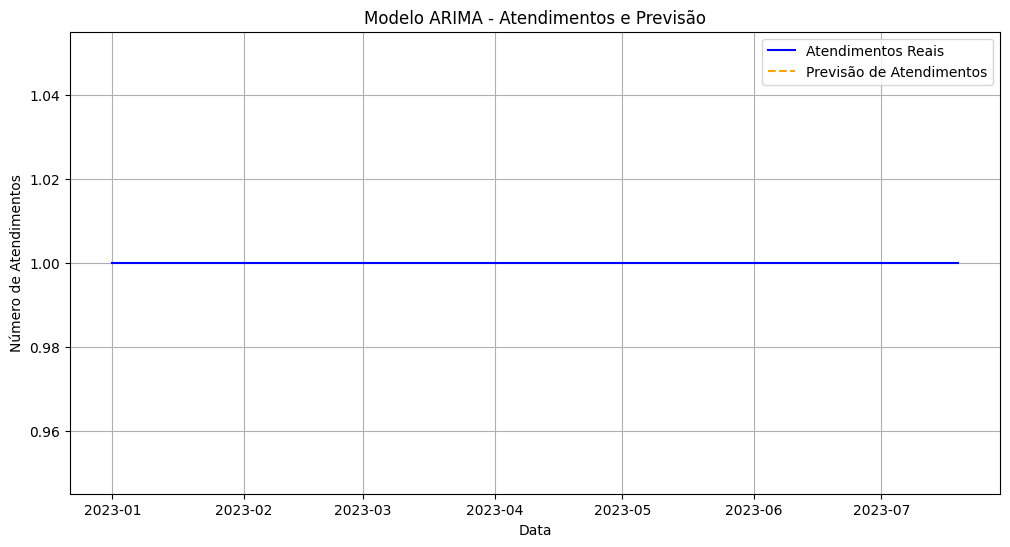

In [27]:
# Prevendo os próximos passos
n_periods = 10  # Número de períodos para previsão
forecast = model_fit.forecast(steps=n_periods)

# Criando um DataFrame para as previsões
forecast_index = pd.date_range(start=df_aggregated.index[-1] + pd.Timedelta(days=1), periods=n_periods, freq='D')
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=['forecast'])

# Plotando os dados
plt.figure(figsize=(12, 6))
plt.plot(df_aggregated['count'], label='Atendimentos Reais', color='blue')
plt.plot(forecast_df['forecast'], label='Previsão de Atendimentos', color='orange', linestyle='--')
plt.title('Modelo ARIMA - Atendimentos e Previsão')
plt.xlabel('Data')
plt.ylabel('Número de Atendimentos')
plt.legend()
plt.grid()
plt.show()

